In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = false)

Args(0.0003, 128, 25, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
include("../test/data.jl")

generate_pattern_dataset (generic function with 1 method)

In [11]:
train_loader, test_loader = getdata(args);

# Test Quadrature Phasor network

In [12]:
model, ps, st = build_mlp(args)

(Chain{@NamedTuple{layer_1::WrappedFunction{var"#5#8"}, layer_2::WrappedFunction{var"#6#9"}, layer_3::PhasorDense, layer_4::WrappedFunction{var"#7#10"}, layer_5::PhasorDense}, Nothing}((layer_1 = WrappedFunction(#5), layer_2 = WrappedFunction(#6), layer_3 = PhasorDense(Dense(2 => 128, use_bias=false), ComplexBias((128,)), Main.PhasorNetworks.complex_to_angle, true, false), layer_4 = WrappedFunction(#7), layer_5 = PhasorDense(Dense(128 => 2, use_bias=false), ComplexBias((2,)), Main.PhasorNetworks.complex_to_angle, true, false)), nothing), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.3048801 1.1494075; -0.6522402 0.105043024; … ; 0.40384468 0.5826767; 0.057744846 -0.4485582],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_4 = Name

In [13]:
pst, stt = train_test(model, args, ps, st, train_loader, test_loader)

[ Info: Training on CPU


Test Summary: | Pass  Total   Time
Training Test |    1      1  12.5s


((layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.32898605 1.0915866; -0.7113596 0.05520681; … ; 0.47720423 0.5440483; 0.041969836 -0.3623357],), bias = (bias_real = Float32[1.061657, 0.92468435, 1.0201254, 1.0699936, 1.0064306, 0.921741, 0.9709999, 0.8940663, 1.0663096, 0.9802608  …  0.897609, 0.9885503, 1.0422472, 1.0356349, 0.9607465, 1.0871557, 0.96457857, 0.9448914, 0.9611185, 1.0369575], bias_imag = Float32[-0.059075765, -0.12676325, -0.03900508, -0.0642061, -0.12942709, -0.07981232, 0.0019725235, 0.058818653, -0.07986147, 0.021168616  …  0.06278302, 0.108621925, -0.07222481, -0.072182424, -0.1109346, 0.01263262, -0.015603454, 0.032780457, -0.09259495, -0.15276763])), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.08020268 -0.033471387 … 0.14957604 0.05177205; -0.14349604 0.04794228 … -0.007841225 -0.12764347],), bias = (bias_real = Float32[1.0105671, 0.94741076], bias_imag = Float32[-0.093618214, 0.1723545]))), (layer_1 = Na

In [15]:
x, y = test_loader[1]

(Float32[0.11148299 -0.0054768324 … -0.09963491 0.017882833; 0.36409417 -0.003913996 … -0.46306604 0.45056552], Bool[0 1 … 0 0; 1 0 … 1 1])

In [16]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::WrappedFunction{var"#17#19"}, layer_2::MakeSpiking, layer_3::PhasorDense, layer_4::WrappedFunction{var"#18#20"}, layer_5::PhasorDense}, Nothing}((layer_1 = WrappedFunction(#17), layer_2 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0), layer_3 = PhasorDense(Dense(2 => 128, use_bias=false), ComplexBias((128,)), Main.PhasorNetworks.soft_angle, true, false), layer_4 = WrappedFunction(#18), layer_5 = PhasorDense(Dense(128 => 2, use_bias=false), ComplexBias((2,)), Main.PhasorNetworks.soft_angle, true, false)), nothing), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[-0.9479386 0.741628; -0.6005563 1.0503145; … ; -1.0991162 -0.5877427; 0.7369396 0.5003056],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [17]:
ys, _ = spk_model(x, pst, stt)

(SpikingCall(Spike Train: (2, 128) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple())))

In [18]:
y2, _ = model(x, pst, stt);

In [19]:
test_batch = [(x,y),]

1-element Vector{Tuple{Matrix{Float32}, OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.11148299 -0.0054768324 … -0.09963491 0.017882833; 0.36409417 -0.003913996 … -0.46306604 0.45056552], [0 1 … 0 0; 1 0 … 1 1])

In [20]:
yh, _ = spk_model(x, pst, stt)

(SpikingCall(Spike Train: (2, 128) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple())))

In [21]:
yhp = train_to_phase(yh);

In [22]:
ls = evaluate_loss(yh, y, :quadrature, reduce_dim=1) |> stack;

In [23]:
size(ls)

(128, 20)

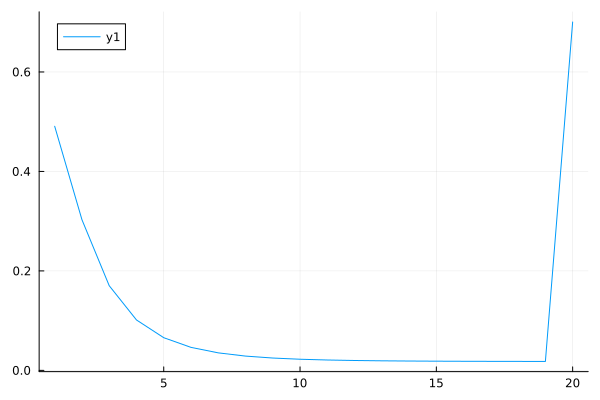

In [24]:
plot(mean(ls, dims=(1)) |> vec)

In [25]:
ls[:,end-1] |> mean

0.018011536f0

In [26]:
evaluate_loss(y2, y, :quadrature, reduce_dim=1) |> stack |> mean

0.014850324f0

In [27]:
prod([1,2,3])

6

In [28]:
ax1 = evaluate_accuracy(y2, y, :quadrature)

(126, 128)

In [29]:
ax1[1]  / ax1[2]

0.984375

In [30]:
evaluate_accuracy(yhp, y, :quadrature)

([57, 125, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 97], 128)

In [31]:
evaluate_accuracy(yh, y, :quadrature)

([57, 125, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 97], 128)

In [32]:
dl, da = spiking_loss_and_accuracy(test_batch, spk_model, pst, stt, args, encoding=:quadrature, repeats=repeats)

(Float32[0.4907986 0.30293787 … 0.018011536 0.7004883], [0.4453125, 0.9765625, 0.984375, 0.984375, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 0.7578125])

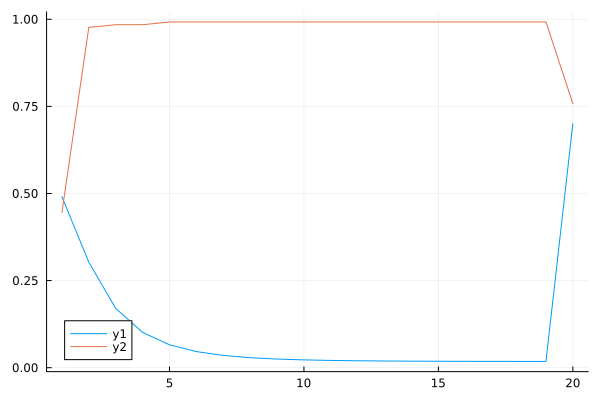

In [33]:
plot(vec(dl))
plot!(vec(da))

In [34]:
sl, sa = loss_and_accuracy(test_batch, model, pst, stt, args, encoding=:quadrature)

(0.014850324f0, 0.984375)

In [35]:
accuracy_test(model, pst, stt, test_loader, args)

Test Summary: | Pass  Total  Time
Accuracy Test |    1      1  0.0s


Test.DefaultTestSet("Accuracy Test", Any[], 1, false, false, true, 1.762212394577833e9, 1.762212394581159e9, false, "/home/wilkie/code/PhasorNetworks.jl/test/network_tests.jl")